In [68]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------------
# 1) Etapa de colecta de Dados (Normalização de nomes de colunas)
# -----------------------------------------------------------------
# Leitura de arquivos CSV usando pandas.

CAMINHO_CONTINENTES = "/home/avindo/Projecto_final/turismo_angola_paises_2010_2023.csv"
CAMINHO_PROV = "/home/avindo/Projecto_final/turismo_angola_provincias_2010_2023.csv"

cont = pd.read_csv(CAMINHO_CONTINENTES)
df_prov = pd.read_csv(CAMINHO_PROV)
print("---CONTINENTE---")
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
print(cont)

print("---PROVINCIA---")
pd.set_option('display.max_rows', None)   # mostra todas as linhas
pd.set_option('display.max_columns', None)  # mostra todas as colunas
print(df_prov)



---CONTINENTE---
      Ano           Pais  Chegadas_Turistas  Saidas_Turistas
0    2010       Portugal              10331             9293
1    2010         Brasil              17849            15793
2    2010          China              22088            18861
3    2010  África do Sul              13066            12370
4    2010        Namíbia              15328            13677
5    2010           Cuba              15685            14235
6    2010        Espanha              18523            15981
7    2010         França              10146             9213
8    2010            EUA              20879            18920
9    2010    Reino Unido               9947             9131
10   2011       Portugal              13962            12395
11   2011         Brasil              21195            19068
12   2011          China              17660            15536
13   2011  África do Sul              10585             9053
14   2011        Namíbia              31558            29497
15   20

In [69]:
# Padronização de nomes de colunas
df_prov.columns = df_prov.columns.str.strip().str.lower().str.normalize('NFKD') \
        .str.encode('ascii', errors='ignore').str.decode('utf-8')
cont.columns = cont.columns.str.strip().str.lower().str.normalize('NFKD') \
        .str.encode('ascii', errors='ignore').str.decode('utf-8')

        
# -------------------------------------------------------------
# 1.2) Limpeza e verificação de valores ausentes
# -------------------------------------------------------------
print('\n--- Missing values (continentes) ---')
print(cont.isnull().sum())

print('\n--- Missing values (províncias) ---')
print(df_prov.isnull().sum())
   


--- Missing values (continentes) ---
ano                  0
pais                 0
chegadas_turistas    0
saidas_turistas      0
dtype: int64

--- Missing values (províncias) ---
ano                  0
provincia            0
chegadas_turistas    0
saidas_turistas      0
variacao_%           0
dtype: int64


In [70]:
#1.3 Limpeza de Dados

# Remove linhas com valores ausentes
cont = cont.dropna()
df_prov = df_prov.dropna()

# -------------------------------------------------------------
# 1.3) Conversão de tipos numéricos
# -------------------------------------------------------------
for col in ['ano', 'chegadas_turistas', 'saidas_turistas', 'variacao(%)']:
    if col in cont.columns:
        cont[col] = pd.to_numeric(cont[col], errors='coerce')

for col in ['ano', 'chegadas_turistas', 'saidas_turistas']:
    if col in df_prov.columns:
        df_prov[col] = pd.to_numeric(df_prov[col], errors='coerce')

cont = cont.dropna()
df_prov = df_prov.dropna()


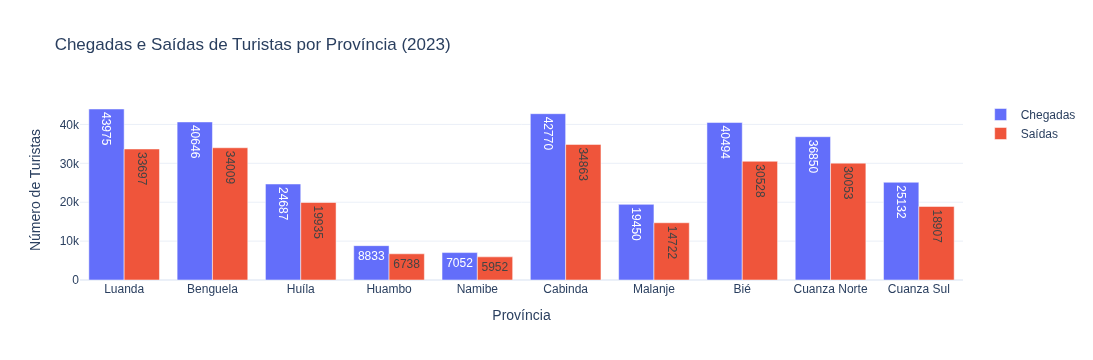

In [71]:
import plotly.graph_objects as go
import numpy as np

# Verifica se a coluna 'provincia' existe
if 'provincia' in df_prov.columns:
    provincias = df_prov['provincia'].unique()
    dados_2021 = df_prov[df_prov['ano'] == 2023]

    # Prepara os dados, preenchendo zeros se houver NAs
    chegadas = dados_2021.set_index('provincia').reindex(provincias)['chegadas_turistas'].fillna(0).values
    saidas = dados_2021.set_index('provincia').reindex(provincias)['saidas_turistas'].fillna(0).values

    # Cria gráfico de barras
    fig = go.Figure()

    largura = 0.4  # largura relativa da barra

    fig.add_trace(go.Bar(
        x=provincias,
        y=chegadas,
        name='Chegadas',
        width=largura,
        text=[int(v) for v in chegadas],
        textposition='auto'
    ))

    fig.add_trace(go.Bar(
        x=provincias,
        y=saidas,
        name='Saídas',
        width=largura,
        text=[int(v) for v in saidas],
        textposition='auto'
    ))

    # Layout
    fig.update_layout(
        title='Chegadas e Saídas de Turistas por Província (2023)',
        xaxis_title='Província',
        yaxis_title='Número de Turistas',
        barmode='group',  # barras lado a lado
        template='plotly_white'
    )

    fig.show()


In [72]:
#1.5 Engenharia de Recursos
    #• Criação de agregados por ano para análises nacionais.

# 4.2 Preparar dados agregados por ano (soma de todos continentes/províncias)
agg_por_ano = cont.groupby('ano')[['chegadas_turistas', 'saidas_turistas']].sum().reset_index()

print('\n--- Agregado por ano (continentes) ---')
print(agg_por_ano)



--- Agregado por ano (continentes) ---
     ano  chegadas_turistas  saidas_turistas
0   2010             153842           137474
1   2011             188683           169265
2   2012             168920           151784
3   2013             141637           126174
4   2014             108799            99850
5   2015             106370            96618
6   2016             134399           123686
7   2017             136612           122549
8   2018             205015           186777
9   2019             135593           122046
10  2020              86653            76178
11  2021             247370           220485
12  2022             200702           179767
13  2023              64467            57741


In [73]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

# Supondo que agg_por_ano já existe:
X = agg_por_ano[['ano']].values
y = agg_por_ano['chegadas_turistas'].values

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []

if len(X) >= 3:
    tscv = TimeSeriesSplit(n_splits=3)
else:
    tscv = None

for name, model in models.items():
    res = {'Modelo': name}

    if tscv is not None:
        scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
        res['R2_CV_Mean'] = scores.mean()
        res['R2_CV_Std'] = scores.std()
    else:
        res['R2_CV_Mean'] = np.nan
        res['R2_CV_Std'] = np.nan

    model.fit(X, y)
    y_pred = model.predict(X)
    res['R2_Insample'] = r2_score(y, y_pred)
    res['RMSE_Insample'] = np.sqrt(mean_squared_error(y, y_pred))

    results.append(res)

# Transformar em DataFrame para exibir bonito
df_results = pd.DataFrame(results)
df_results = df_results.round(4)  # arredonda os números para 4 casas decimais

print("\n--- Resultados dos modelos (agregado nacional) ---")
display(df_results)







--- Resultados dos modelos (agregado nacional) ---


,Modelo,R2_CV_Mean,R2_CV_Std,R2_Insample,RMSE_Insample
0,LinearRegression,-2.4090,2.7793,0.0026,48153.082
1,RandomForest,-0.2641,0.2679,0.8287,19952.760


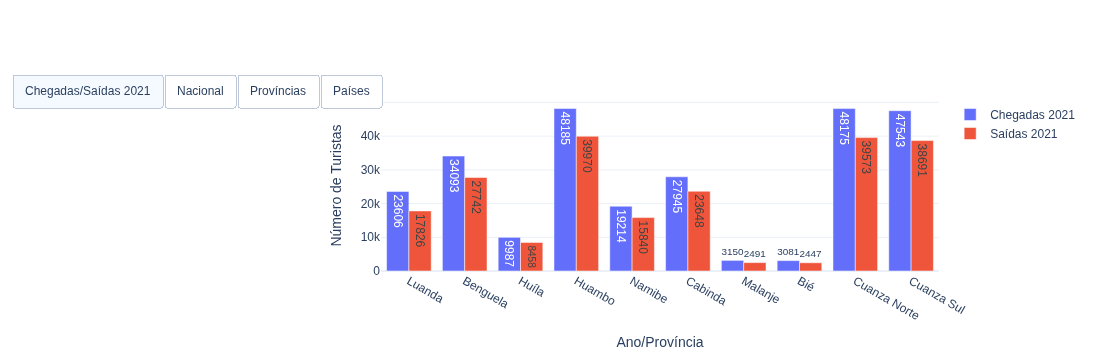

In [74]:
import plotly.graph_objects as go
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# -----------------------------
# Dados de exemplo
# -----------------------------
# agg_por_ano: df com 'ano', 'chegadas_turistas', 'saidas_turistas'
# prov: df com 'provincia', 'ano', 'chegadas_turistas', 'saidas_turistas'
# cont: df com 'pais', 'ano', 'chegadas_turistas'
# models: dict com modelos treinados para previsões nacionais

anos_futuros_nacional = np.arange(2026, 2030)

fig = go.Figure()

# -----------------------------
# 1) Chegadas e saídas 2021 por província
# -----------------------------
if 'provincia' in df_prov.columns:
    provincias = df_prov['provincia'].unique()
    dados_2021 =df_prov[df_prov['ano'] == 2021]
    chegadas = dados_2021.set_index('provincia').reindex(provincias)['chegadas_turistas'].fillna(0).values
    saidas = dados_2021.set_index('provincia').reindex(provincias)['saidas_turistas'].fillna(0).values

    fig.add_trace(go.Bar(
        x=provincias,
        y=chegadas,
        name='Chegadas 2021',
        text=[int(v) for v in chegadas],
        textposition='auto',
        visible=True
    ))

    fig.add_trace(go.Bar(
        x=provincias,
        y=saidas,
        name='Saídas 2021',
        text=[int(v) for v in saidas],
        textposition='auto',
        visible=True
    ))

# -----------------------------
# 2) Previsões Nacionais
# -----------------------------
# Dados reais
fig.add_trace(go.Scatter(
    x=agg_por_ano['ano'],
    y=agg_por_ano['chegadas_turistas'],
    mode='lines+markers',
    name='Chegadas Reais',
    line=dict(color='black', width=2),
    visible=False
))

# Previsões
if isinstance(models, dict):
    for name, model in models.items():
        preds = model.predict(anos_futuros_nacional.reshape(-1,1))
        fig.add_trace(go.Scatter(
            x=anos_futuros_nacional,
            y=preds,
            mode='lines+markers',
            name=f'Previsão {name}',
            line=dict(dash='dash'),
            visible=False
        ))
else:
    preds = models.predict(anos_futuros_nacional.reshape(-1,1))
    fig.add_trace(go.Scatter(
        x=anos_futuros_nacional,
        y=preds,
        mode='lines+markers',
        name='Previsão',
        line=dict(dash='dash'),
        visible=False
    ))

# -----------------------------
# 3) Previsões por Província
# -----------------------------
prov_selec = ['Luanda','Benguela','Huíla']
for prov_name in prov_selec:
    dados_prov = df_prov[df_prov['provincia']==prov_name]
    
    # Dados reais
    fig.add_trace(go.Scatter(
        x=dados_prov['ano'],
        y=dados_prov['chegadas_turistas'],
        mode='lines+markers',
        name=f'{prov_name} Reais',
        visible=False
    ))
    
    # Previsão com RandomForest
    X_future = np.arange(dados_prov['ano'].max()+1, 2026).reshape(-1,1)
    modelo = RandomForestRegressor(random_state=42)
    modelo.fit(dados_prov[['ano']], dados_prov['chegadas_turistas'])
    preds = modelo.predict(X_future)
    
    fig.add_trace(go.Scatter(
        x=X_future.flatten(),
        y=preds,
        mode='lines+markers',
        name=f'{prov_name} Previsão',
        line=dict(dash='dash'),
        visible=False
    ))

# -----------------------------
# 4) Previsões por País/Continente
# -----------------------------
pais_selec = ['Portugal','Brasil','China']
for pais_name in pais_selec:
    dados_pais = cont[cont['pais']==pais_name]
    
    # Dados reais
    fig.add_trace(go.Scatter(
        x=dados_pais['ano'],
        y=dados_pais['chegadas_turistas'],
        mode='lines+markers',
        name=f'{pais_name} Reais',
        visible=False
    ))
    
    # Previsão com RandomForest
    X_future = np.arange(dados_pais['ano'].max()+1, 2026).reshape(-1,1)
    modelo = RandomForestRegressor(random_state=42)
    modelo.fit(dados_pais[['ano']], dados_pais['chegadas_turistas'])
    preds = modelo.predict(X_future)
    
    fig.add_trace(go.Scatter(
        x=X_future.flatten(),
        y=preds,
        mode='lines+markers',
        name=f'{pais_name} Previsão',
        line=dict(dash='dash'),
        visible=False
    ))

# -----------------------------
# Botões interativos para alternar abas
# -----------------------------
num_nacional = len(models) + 1 if isinstance(models, dict) else 2
num_prov = len(prov_selec)*2
num_pais = len(pais_selec)*2

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.0,
            y=1.15,
            buttons=list([
                dict(label="Chegadas/Saídas 2021",
                     method="update",
                     args=[{"visible": [True]*2 + [False]*(len(fig.data)-2)},
                           {"title": "Chegadas e Saídas por Província (2021)"}]),
                dict(label="Nacional",
                     method="update",
                     args=[{"visible": [False]*2 + [True]*num_nacional + [False]*(len(fig.data)-2-num_nacional)},
                           {"title": "Chegadas Reais e Previsões Nacionais (2022–2025)"}]),
                dict(label="Províncias",
                     method="update",
                     args=[{"visible": [False]*2 + [False]*num_nacional + [True]*num_prov + [False]*(len(fig.data)-2-num_nacional-num_prov)},
                           {"title": "Chegadas Reais e Previsões por Província (2022–2025)"}]),
                dict(label="Países",
                     method="update",
                     args=[{"visible": [False]*2 + [False]*num_nacional + [False]*num_prov + [True]*num_pais},
                           {"title": "Chegadas Reais e Previsões por País/Continente (2022–2025)"}])
            ]),
        )
    ]
)

# Layout geral
fig.update_layout(
    template='plotly_white',
    xaxis_title='Ano/Província',
    yaxis_title='Número de Turistas',
    showlegend=True
)

fig.show()


In [75]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Dicionários para armazenar modelos e previsões
prov_models = {}
anos_future = np.arange(2024, 2030)
prov_previsoes = []

# Garantir que df_prov tenha a coluna 'saidas_turistas'
for prov_name in df_prov['provincia'].unique():
    sub = df_prov[df_prov['provincia'] == prov_name].sort_values('ano')
    if sub.shape[0] < 2:
        continue  # Sem dados suficientes para treinar
    
    # Agora usamos ano + saídas de turistas como features
    Xprov = sub[['ano', 'saidas_turistas']].values
    yprov = sub['chegadas_turistas'].values
    
    m = LinearRegression()
    m.fit(Xprov, yprov)
    
    prov_models[prov_name] = m
    
    # Para prever anos futuros, vamos assumir que as saídas futuras são iguais ao último ano conhecido
    ult_saidas = sub['saidas_turistas'].iloc[-1]
    futuros = np.column_stack((anos_future, [ult_saidas]*len(anos_future)))
    
    preds = m.predict(futuros)
    
    # Armazena as previsões de forma organizada
    for ano, valor in zip(anos_future, preds):
        prov_previsoes.append({
            'Provincia': prov_name,
            'Ano': int(ano),
            'Previsao_Chegadas': int(valor)
        })

# Transformar em DataFrame para exibir bonito
df_previsoes = pd.DataFrame(prov_previsoes)

# Mostrar previsões das primeiras 20 linhas como exemplo
print('\n--- Previsões por província (2024-2030) ---')
display(df_previsoes.head(20))



--- Previsões por província (2024-2030) ---


,Provincia,Ano,Previsao_Chegadas
0,Luanda,2024,43230
1,Luanda,2025,43338
2,Luanda,2026,43445
3,Luanda,2027,43553
4,Luanda,2028,43660
5,Luanda,2029,43768
6,Benguela,2024,43056
7,Benguela,2025,43095
8,Benguela,2026,43133
9,Benguela,2027,43172


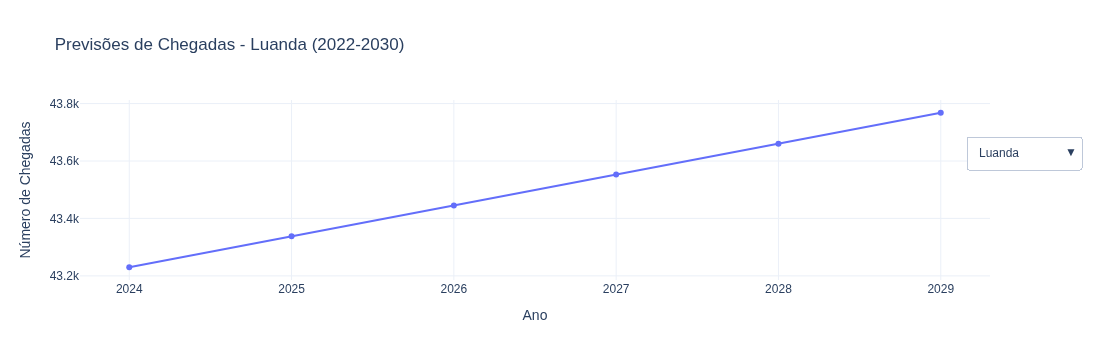

In [76]:
import plotly.graph_objects as go

# Lista de províncias únicas
provincias = df_previsoes['Provincia'].unique()

# Criar figura
fig = go.Figure()

# Adiciona todas as províncias como traces, inicialmente visíveis apenas a primeira
for i, prov_name in enumerate(provincias):
    df_temp = df_previsoes[df_previsoes['Provincia'] == prov_name]
    fig.add_trace(go.Scatter(
        x=df_temp['Ano'],
        y=df_temp['Previsao_Chegadas'],
        mode='lines+markers',
        name=prov_name,
        visible=(i==0)  # só a primeira província visível inicialmente
    ))

# Criar botões dropdown
buttons = []
for i, prov_name in enumerate(provincias):
    # Cria lista de visibilidades para todos os traces
    visibility = [False] * len(provincias)
    visibility[i] = True  # somente a província selecionada visível
    buttons.append(dict(
        label=prov_name,
        method="update",
        args=[{"visible": visibility},
              {"title": f"Previsões de Chegadas - {prov_name} (2022-2030)"}]
    ))

# Layout com dropdown
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.1,
        y=0.8
    )],
    title=f"Previsões de Chegadas - {provincias[0]} (2022-2030)",
    xaxis_title='Ano',
    yaxis_title='Número de Chegadas',
    template='plotly_white'
)

fig.show()


In [32]:
# -------------------------------------------------------------
# 6) Salvamento em CSV
# -------------------------------------------------------------
out = pd.DataFrame({'ano': anos_future})
for prov_name, preds in prov_previsoes.items():
    out[f'previsao_{prov_name}'] = [int(p) for p in preds]

out.to_csv('previsoes_chegadas_2022_2030.csv', index=False)
print('\nArquivo "previsoes_chegadas_2022_2030.csv" salvo no diretório atual.')



Arquivo "previsoes_chegadas_2022_2030.csv" salvo no diretório atual.
